Load python packages

In [2]:
# I'm sure loads of these are unnecessary!

import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import glob
import copernicusmarine
from pathlib import Path
import xarray as xr
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from datetime import datetime
import netCDF4
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import matplotlib.colors as colors
import numpy as np
import geopandas as gpd

Load data from directories, establish some spatial variables

In [3]:
parent_dir    = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir      = os.path.join(parent_dir, 'data')
satellite_dir = os.path.join(data_dir, 'satellite')
output_dir = os.path.join(parent_dir, 'Output/sat_plot')
file_pattern  = os.path.join(satellite_dir, '*.nc')

satellite_files = glob.glob(file_pattern)

chla_data = xr.open_dataset(os.path.join(satellite_dir, 'CMEMS_Iceland_Basin_CHLA_April-May2024.nc')) # Unsure how this would behave with multiple netCDF files

#print(chla_data.variables.keys) #Uncomment to display netCDF file contents

min_lon = -35
max_lon = -5
min_lat = 55
max_lat = 66

In [4]:
color = 'YlGnBu_r'

In [5]:
wmo_list = [4903532, 1902637]
#Float 1 = test float in the Icelandic Bassin
float_1_url = 'https://data-argo.ifremer.fr/dac/aoml/4903532/4903532_Sprof.nc'
#Float 2 = test float on Custard with glider next to it
float_2_url = 'https://data-argo.ifremer.fr/dac/coriolis/1902637/1902637_Sprof.nc'

#List the floats
floats_url = [float_1_url, float_2_url]

#Assign the local float directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
floats_dir =  os.path.join(parent_dir, 'Data/Floats')

#Create floats filename
floats_filenames = []
for i in floats_url:
    filename = floats_dir + '/' + i.rsplit('/', 1)[1]
    floats_filenames.append(filename)

In [6]:
position_df = pd.DataFrame({'PROF_NUM' : str(), 'LONGITUDE' : [], 'LATITUDE' : [], 'float' : int()})
last_position_df = pd.DataFrame({'PROF_NUM' : str(), 'LONGITUDE' : [], 'LATITUDE' : [], 'float' : int()})
for file, wmo in zip(floats_filenames, wmo_list):
    dat = xr.open_dataset(file)
    dat = dat.rename({'CYCLE_NUMBER':'PROF_NUM'}).swap_dims({'N_PROF':'PROF_NUM'})
    temp_df = dat[['LONGITUDE', 'LATITUDE', 'JULD']].to_dataframe().reset_index()
    temp_df['float'] = wmo
    last_temp_df = temp_df[temp_df['JULD'] == max(temp_df['JULD'])]

    last_position_df = pd.concat([last_position_df, last_temp_df], ignore_index=True)
    position_df = pd.concat([position_df, temp_df], ignore_index=True)
    dat.close()
position_df = position_df[position_df['LATITUDE'] > min_lat]

C:\Users\flapet\AppData\Local\Temp\ipykernel_21720\1292524950.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  last_position_df = pd.concat([last_position_df, last_temp_df], ignore_index=True)
C:\Users\flapet\AppData\Local\Temp\ipykernel_21720\1292524950.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  position_df = pd.concat([position_df, temp_df], ignore_index=True)


In [7]:
# We load shape files for topographic lines
first_line_path = 'c:\\Users\\flapet\\OneDrive - NOC\\Documents\\NRT_viz\\biocarbon_nrt_data_viz/Data/ne_10m_bathymetry_all/ne_10m_bathymetry_J_1000.shp'
second_line_path = 'c:\\Users\\flapet\\OneDrive - NOC\\Documents\\NRT_viz\\biocarbon_nrt_data_viz/Data/ne_10m_bathymetry_all/ne_10m_bathymetry_I_2000.shp'

gdf_1000 = gpd.read_file(first_line_path)
gdf_2000 = gpd.read_file(second_line_path)

In [8]:
# define the caracteristics of the map and the features to plot
plotting = False
if plotting == True :
    for i in tqdm(range(len(chla_data['time'].data))):
        plotname = output_dir + '/' + 'Chla' + str(i) + '.png'
        date_of_plot = chla_data['time'].data[i]
        plot_title = 'Chlorophyll a ' + np.datetime_as_string(date_of_plot, unit='D')
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

        ax.set_title(plot_title,fontsize=24)
        im = ax.pcolormesh(chla_data['longitude'].data, chla_data['latitude'].data, chla_data['CHL'].data[i,:], vmin = 0, vmax = 2 ,cmap = color, transform=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        sc = ax.scatter(position_df['LONGITUDE'], position_df['LATITUDE'], transform=ccrs.PlateCarree(), c = 'black', zorder = 3)
        sc2 = ax.scatter(last_position_df['LONGITUDE'], last_position_df['LATITUDE'], transform=ccrs.PlateCarree(), c = 'red', zorder = 4)

        gdf_1000.plot(ax=ax, transform=ccrs.PlateCarree(), linewidth=0.5, edgecolor='k', facecolor='none')
        gdf_2000.plot(ax=ax, transform=ccrs.PlateCarree(), linewidth=0.3, edgecolor='k', facecolor='none')

        gl = ax.gridlines(draw_labels=True,x_inline=False,y_inline=False, crs=ccrs.PlateCarree())
        gl.top_labels=False   # suppress top labels
        gl.right_labels=False # suppress right labels

        cbar = plt.colorbar(im, ax = ax, label=r'Chlorophyll a surface concentration (mg m$^{-3}$)')
        cbar.set_label('Chla', rotation=270, labelpad=15)
        plt.savefig(plotname)
        plt.close()

In [9]:
#import matplotlib
#matplotlib.use('Agg')

In [10]:
# define the caracteristics of the map and the features to plot
plotting_log = False
if plotting_log == True :
    for i in tqdm(range(len(chla_data['time'].data))):
        plotname = output_dir + '/' + 'Chla' + str(i) + '.png'
        date_of_plot = chla_data['time'].data[i]
        plot_title = 'Chlorophyll a ' + np.datetime_as_string(date_of_plot, unit='D')
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

        ax.set_title(plot_title,fontsize=24)
        im = ax.pcolormesh(chla_data['longitude'].data, chla_data['latitude'].data,chla_data['CHL'].data[i,:],cmap = color, norm=colors.LogNorm(), transform=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        sc = ax.scatter(position_df['LONGITUDE'], position_df['LATITUDE'], transform=ccrs.PlateCarree(), c = 'black', zorder = 3)
        sc2 = ax.scatter(last_position_df['LONGITUDE'], last_position_df['LATITUDE'], transform=ccrs.PlateCarree(), c = 'red', zorder = 4)

        gdf_1000.plot(ax=ax, transform=ccrs.PlateCarree(), linewidth=0.5, edgecolor='k', facecolor='none')
        gdf_2000.plot(ax=ax, transform=ccrs.PlateCarree(), linewidth=0.3, edgecolor='k', facecolor='none')

        gl = ax.gridlines(draw_labels=True,x_inline=False,y_inline=False, crs=ccrs.PlateCarree())
        gl.top_labels=False   # suppress top labels
        gl.right_labels=False # suppress right labels

        cbar = plt.colorbar(im, ax = ax, label=r'Chlorophyll a surface concentration (mg m$^{-3}$)')
        cbar.set_label('Chla', rotation=270, labelpad=15)
        plt.savefig(plotname)
        plt.clf()
        plt.close()

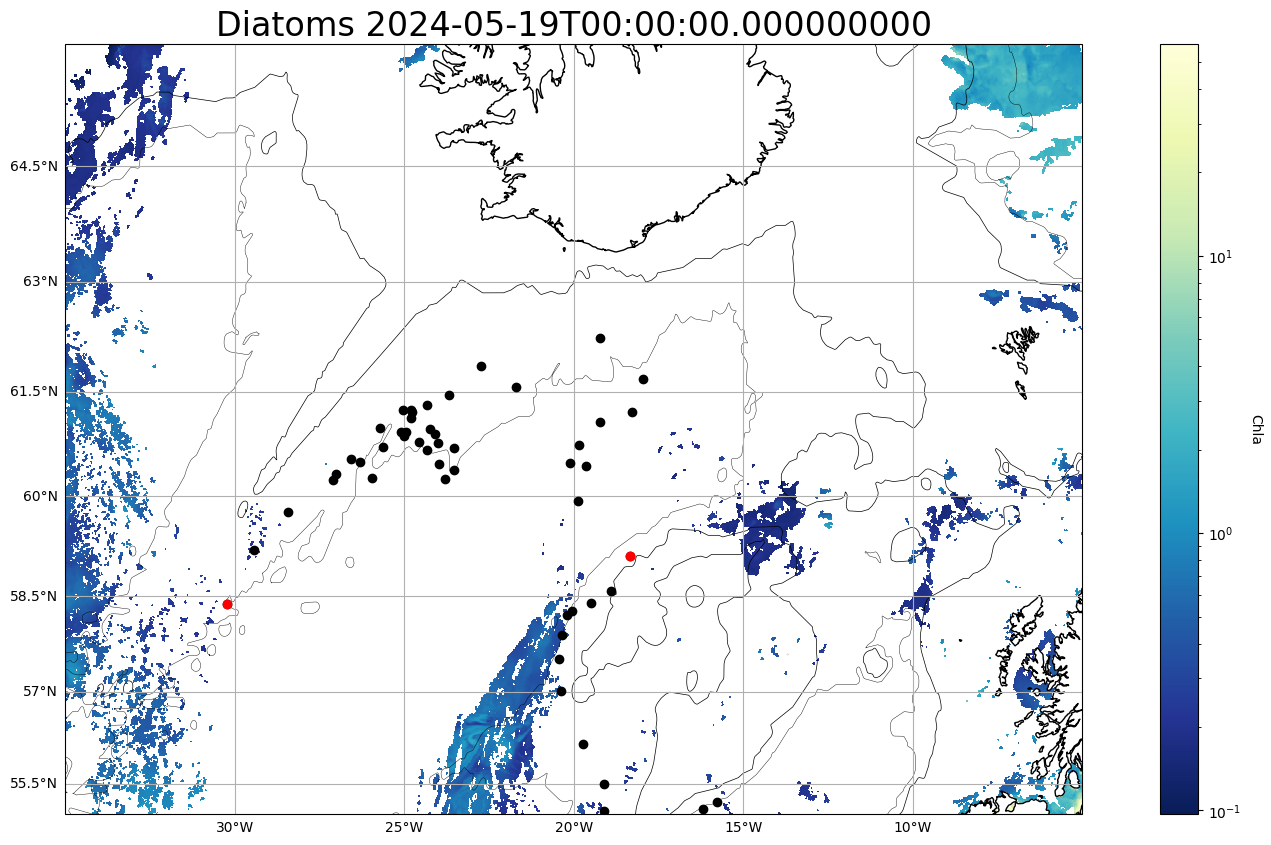

In [12]:
i= 16
plotname = output_dir + '/' + 'Chla' + str(i) + '.png'
date_of_plot = chla_data['time'].data[i]
plot_title = 'Diatoms ' + str(date_of_plot)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())

ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

ax.set_title(plot_title,fontsize=24)
im = ax.pcolormesh(chla_data['longitude'].data, chla_data['latitude'].data,chla_data['CHL'].data[i,:],cmap = color, norm=colors.LogNorm(), transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
sc = ax.scatter(position_df['LONGITUDE'], position_df['LATITUDE'], transform=ccrs.PlateCarree(), c = 'black', zorder = 3)
sc2 = ax.scatter(last_position_df['LONGITUDE'], last_position_df['LATITUDE'], transform=ccrs.PlateCarree(), c = 'red', zorder = 4)

gdf_1000.plot(ax=ax, transform=ccrs.PlateCarree(), linewidth=0.5, edgecolor='k', facecolor='none')
gdf_2000.plot(ax=ax, transform=ccrs.PlateCarree(), linewidth=0.3, edgecolor='k', facecolor='none')

gl = ax.gridlines(draw_labels=True,x_inline=False,y_inline=False, crs=ccrs.PlateCarree())
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels

cbar = plt.colorbar(im, ax = ax, label=r'Chlorophyll a surface concentration (mg m$^{-3}$)')
cbar.set_label('Chla', rotation=270, labelpad=15)
plt.show()
plt.close()

In [13]:
current_data = xr.open_dataset(os.path.join(satellite_dir, 'CMEMS_Iceland_Basin_SSH_April-May2024.nc'))

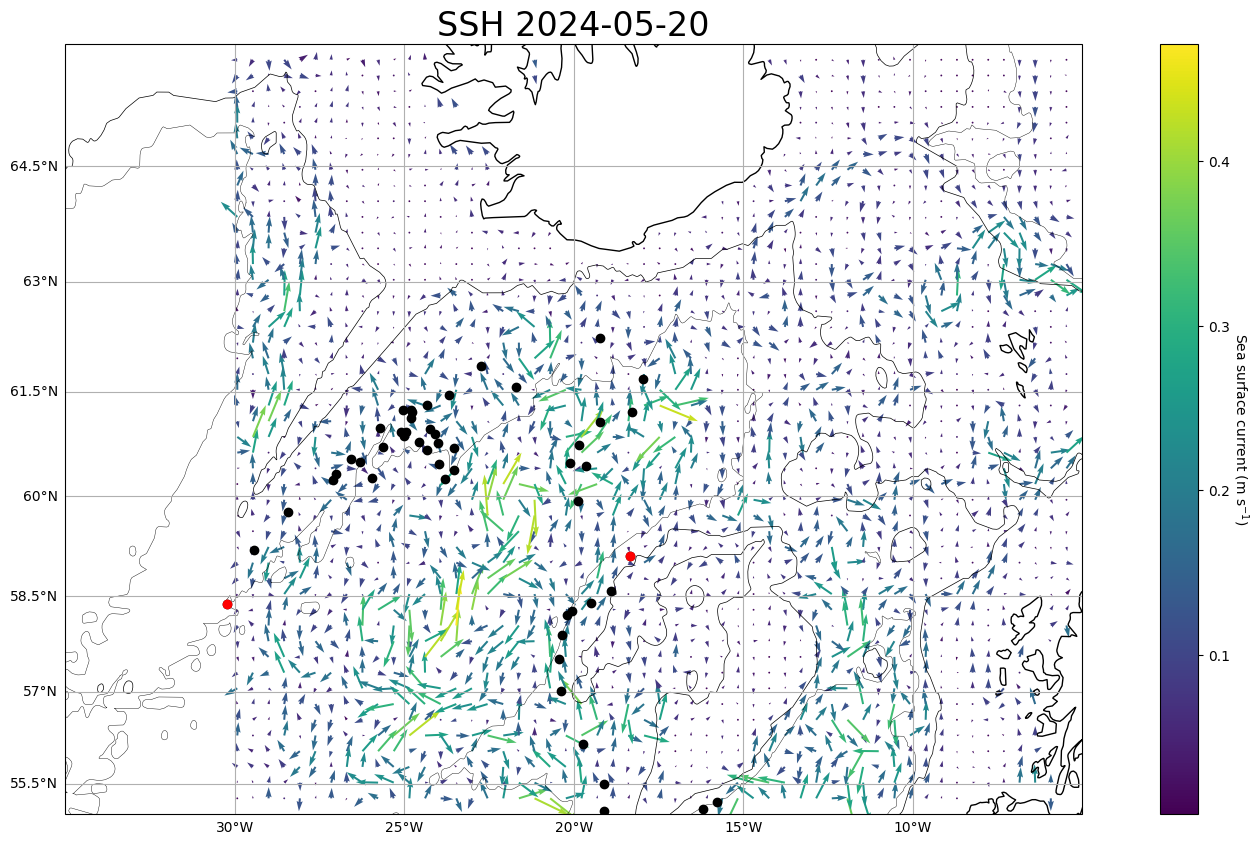

In [38]:
i= 17

x = current_data['longitude'].data
y = current_data['latitude'].data
u = current_data['ugos'].data[i,:]
v = current_data['vgos'].data[i,:]
speed = np.sqrt(U**2 + V**2)

vector_crs = ccrs.PlateCarree()

plotname = output_dir + '/' + 'SSH' + str(i) + '.png'
date_of_plot = chla_data['time'].data[i]
plot_title = 'Surface current ' + np.datetime_as_string(date_of_plot, unit='D')
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())

ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

ax.set_title(plot_title,fontsize=24)
im = ax.quiver(x, y, u, v, speed, angles='xy', scale_units='xy', cmap='viridis', transform=vector_crs, regrid_shape=50, width = 0.002)
ax.coastlines('50m')

sc = ax.scatter(position_df['LONGITUDE'], position_df['LATITUDE'], transform=ccrs.PlateCarree(), c = 'black', zorder = 3)
sc2 = ax.scatter(last_position_df['LONGITUDE'], last_position_df['LATITUDE'], transform=ccrs.PlateCarree(), c = 'red', zorder = 4)

gdf_1000.plot(ax=ax, transform=ccrs.PlateCarree(), linewidth=0.5, edgecolor='k', facecolor='none')
gdf_2000.plot(ax=ax, transform=ccrs.PlateCarree(), linewidth=0.3, edgecolor='k', facecolor='none')

gl = ax.gridlines(draw_labels=True,x_inline=False,y_inline=False, crs=ccrs.PlateCarree())
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels

cbar = plt.colorbar(im, ax = ax, label=r'Sea surface current (m s$^{-1}$)')
cbar.set_label(r'Sea surface current (m s$^{-1}$)', rotation=270, labelpad=15)


ax.set_rasterized(True)
plt.show()
plt.close()

In [31]:
u.shape

(88, 201)